## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

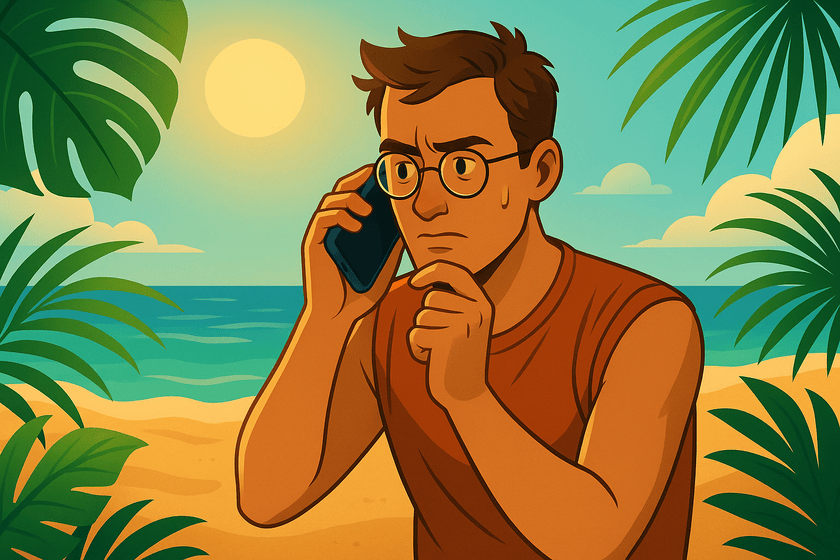

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

In [2]:
# ładowanie zbioru danych
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay,f1_score, precision_recall_fscore_support
import itertools
import time
import os
import random

Pobranie datasetu i stworzenie zbiórów: treningowy, walidacyjny i testowy.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator())

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

(55000, 5000, 10000)

Nasępnie zrobiłem zwykłą sieć neuronową z 3 warstwanmi liniowymi i funkcjami aktywacji ReLu
 jako baseline do porównania przyszłych wyników sieci z warstwami konwolucyjnmi.

In [5]:
class BasicNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(28*28, 128)
    self.fc2 = nn.Linear(128,64)
    self.out = nn.Linear(64,10)

  def forward(self, x):
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x
model_NN = BasicNN()

Mam 2 klasy z sieciami konwulacyjnymi: SimpleCNN - sieć bazową i CNN_2 do zmieniania struktury sieci i porównywania wyników


1.   Element listy
2.   Element listy



In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model_CNN = SimpleCNN()

In [14]:
class CNN_v2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
model_CNN = CNN_v2()

In [15]:
import time
import torch
import torch.nn as nn
from torch.optim import Adam

def run_epoch(model, optimizer, criterion, loader, train: bool):
    epoch_loss, correct, total = 0.0, 0, 0
    model.train() if train else model.eval()

    for image, label in loader:
        if train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            output = model(image)
            loss = criterion(output, label)
            if train:
                loss.backward()
                optimizer.step()

        epoch_loss += loss.item() * image.size(0)
        preds = output.argmax(1)
        correct += (preds == label).sum().item()
        total += label.size(0)

    return epoch_loss / total, correct / total

models = {
    "Zwykla_Siec":  model_NN,
    "Siec_CNN":     model_CNN,
}

EPOCHS = 5
lr = 1e-3
start = time.time()
histories = {}

for name, model in models.items():
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, EPOCHS + 1):
        tr_loss, tr_acc = run_epoch(model, optimizer, criterion, train_loader, train=True)
        va_loss, va_acc = run_epoch(model, optimizer, criterion, val_loader,   train=False)  # optimizer nie jest używany, ale sygnatura zostaje

        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)

        print(f"[{name}] Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"val loss {va_loss:.4f} acc {va_acc:.4f}")

    histories[name] = history

print(f"Czas treningu: {time.time() - start:.1f}s")



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Zwykla_Siec] Ep 01/5 | train loss 0.0273 acc 0.9909 | val loss 0.1166 acc 0.9740
[Zwykla_Siec] Ep 02/5 | train loss 0.0206 acc 0.9934 | val loss 0.1263 acc 0.9746
[Zwykla_Siec] Ep 03/5 | train loss 0.0223 acc 0.9924 | val loss 0.1129 acc 0.9762
[Zwykla_Siec] Ep 04/5 | train loss 0.0198 acc 0.9937 | val loss 0.1562 acc 0.9738
[Zwykla_Siec] Ep 05/5 | train loss 0.0181 acc 0.9944 | val loss 0.1343 acc 0.9764
[Siec_CNN] Ep 01/5 | train loss 0.1748 acc 0.9461 | val loss 0.0587 acc 0.9812
[Siec_CNN] Ep 02/5 | train loss 0.0750 acc 0.9773 | val loss 0.0455 acc 0.9866
[Siec_CNN] Ep 03/5 | train loss 0.0577 acc 0.9826 | val loss 0.0565 acc 0.9832
[Siec_CNN] Ep 04/5 | train loss 0.0476 acc 0.9854 | val loss 0.0389 acc 0.9872
[Siec_CNN] Ep 05/5 | train loss 0.0408 acc 0.9872 | val loss 0.0386 acc 0.9882
Czas treningu: 253.3s


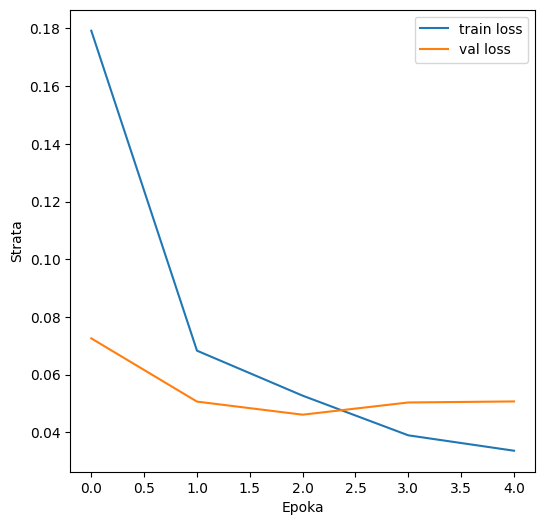

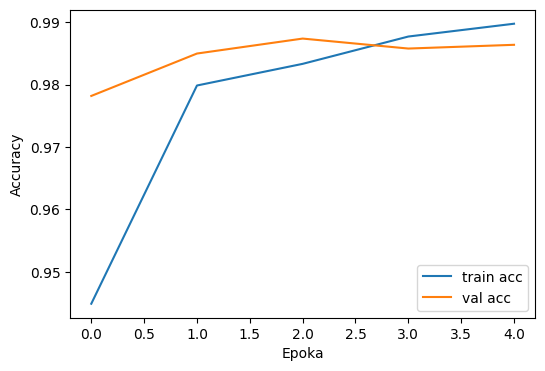

In [8]:
plt.figure(figsize=(6,6))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.xlabel("Epoka")
plt.ylabel("Strata")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history["train_acc"], label="train acc")
plt.plot(history["val_acc"], label="val acc")
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Do ewaluacji modelu wybrałem metryki: accuracy - zbalansowe klasy, więc accuracy będzie odpowiednie, confusion matrix - można zobaczyć, które cyfry mylą się z którymi, oraz zwiuzalizowany f1 score dla każdej klasy - mimo że rozpozanwia pisma to nie jest wykrywania raka, gdzię błędy False Negative śa tragiczne w skutkach, to myślę że na wykresie zawierającym każda klasę posorotwana rosnąca według F1 można zobaczyć, przy której cyfrze nasz model najczęscięj sie myli.

Test accuracy: 0.9904


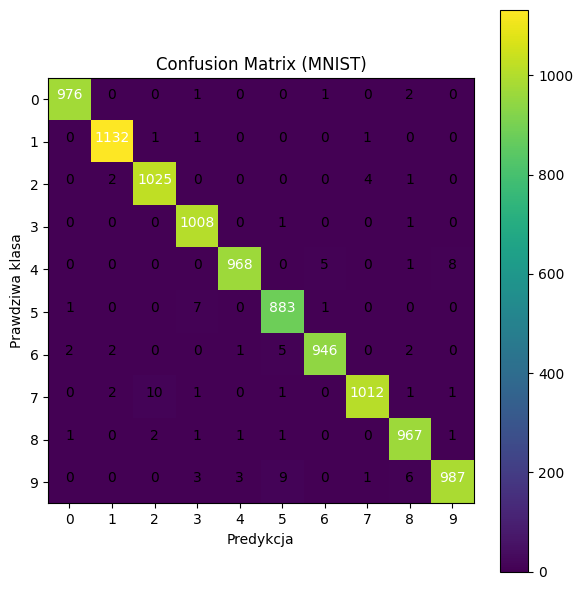

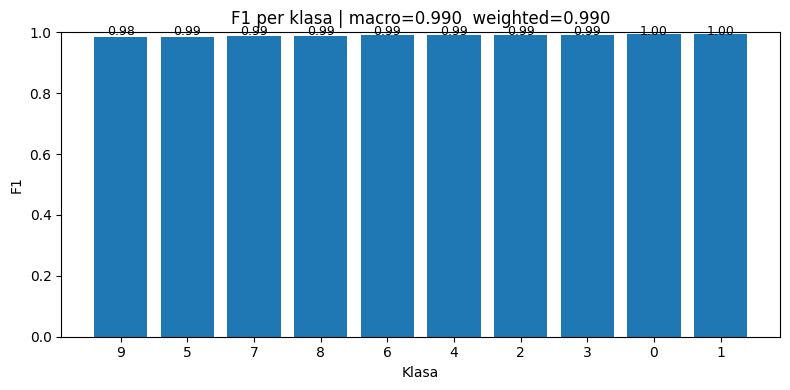

              precision    recall  f1-score   support

           0     0.9959    0.9959    0.9959       980
           1     0.9947    0.9974    0.9960      1135
           2     0.9875    0.9932    0.9903      1032
           3     0.9863    0.9980    0.9921      1010
           4     0.9949    0.9857    0.9903       982
           5     0.9811    0.9899    0.9855       892
           6     0.9927    0.9875    0.9901       958
           7     0.9941    0.9844    0.9892      1028
           8     0.9857    0.9928    0.9893       974
           9     0.9900    0.9782    0.9840      1009

    accuracy                         0.9904     10000
   macro avg     0.9903    0.9903    0.9903     10000
weighted avg     0.9904    0.9904    0.9904     10000



In [16]:
model_CNN.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model_CNN(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

labels = np.unique(np.concatenate([y_true, y_pred]))
p, r, f1, s = precision_recall_fscore_support(
    y_true, y_pred, labels=labels, average=None, zero_division=0
)

order = np.argsort(f1)
labels_sorted = labels[order]
f1_sorted = f1[order]

f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average="weighted", zero_division=0)

plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(labels_sorted)), f1_sorted)
plt.xticks(np.arange(len(labels_sorted)), [str(l) for l in labels_sorted])
plt.ylim(0, 1.0)
plt.ylabel("F1")
plt.xlabel("Klasa")
plt.title(f"F1 per klasa | macro={f1_macro:.3f}  weighted={f1_weighted:.3f}")

for i, v in enumerate(f1_sorted):
    plt.text(i, min(v + 0.02, 0.98), f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

Bazowa struktura CNN - 99.3 % skuteczności
Zmieniona struktura CNN - 99% (elf.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
self.conv2 = nn.Conv2d(16, 64, kernel_size=3, padding=1)
self.pool  = nn.MaxPool2d(2, 2)
self.dropout = nn.Dropout(0.3)
self.fc1  = nn.Linear(64 * 7 * 7, 128)
self.fc2  = nn.Linear(128, num_classes)
Architektura z wykorszytaniem stride zamiast poolingu - 97%(
self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=2)
self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
self.dropout = nn.Dropout(0.25)
self.fc1  = nn.Linear(64 * 7 * 7, 128)
self.fc2  = nn.Linear(128, num_classes))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test accuracy: 0.9747


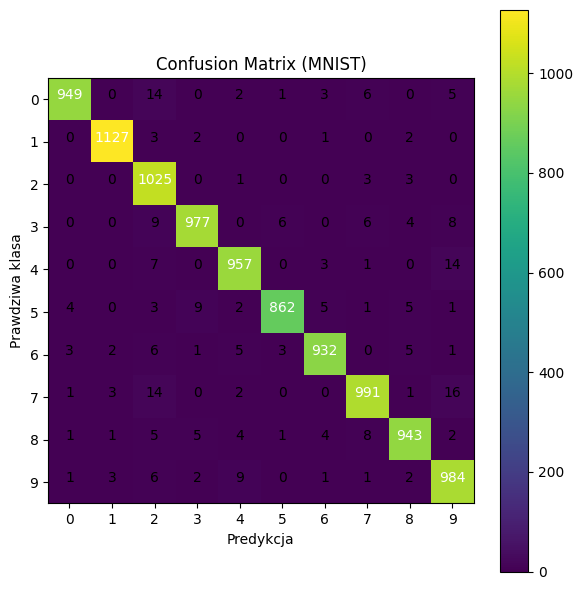

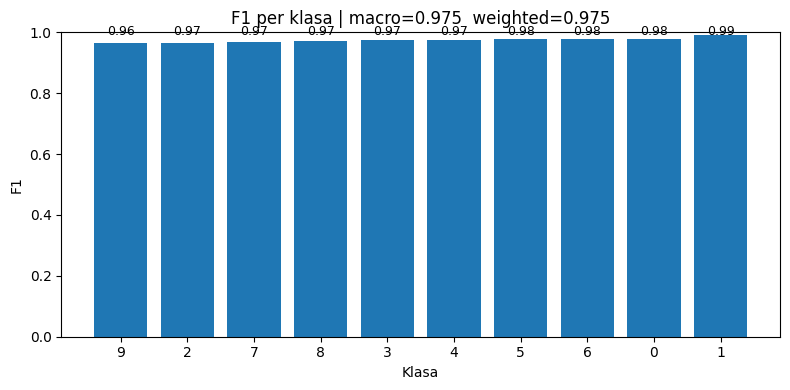

              precision    recall  f1-score   support

           0     0.9896    0.9684    0.9789       980
           1     0.9921    0.9930    0.9925      1135
           2     0.9386    0.9932    0.9652      1032
           3     0.9809    0.9673    0.9741      1010
           4     0.9745    0.9745    0.9745       982
           5     0.9874    0.9664    0.9768       892
           6     0.9821    0.9729    0.9775       958
           7     0.9744    0.9640    0.9692      1028
           8     0.9772    0.9682    0.9727       974
           9     0.9544    0.9752    0.9647      1009

    accuracy                         0.9747     10000
   macro avg     0.9751    0.9743    0.9746     10000
weighted avg     0.9750    0.9747    0.9747     10000



In [10]:
model_NN.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model_NN(xb)
        preds = logits.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

test_acc = (y_pred == y_true).mean()
print(f"Test accuracy: {test_acc:.4f}")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (MNIST)")
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Prawdziwa klasa')
plt.xlabel('Predykcja')
plt.tight_layout()
plt.show()

labels = np.unique(np.concatenate([y_true, y_pred]))
p, r, f1, s = precision_recall_fscore_support(
    y_true, y_pred, labels=labels, average=None, zero_division=0
)

order = np.argsort(f1)
labels_sorted = labels[order]
f1_sorted = f1[order]

f1_macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average="weighted", zero_division=0)

plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(labels_sorted)), f1_sorted)
plt.xticks(np.arange(len(labels_sorted)), [str(l) for l in labels_sorted])
plt.ylim(0, 1.0)
plt.ylabel("F1")
plt.xlabel("Klasa")
plt.title(f"F1 per klasa | macro={f1_macro:.3f}  weighted={f1_weighted:.3f}")

for i, v in enumerate(f1_sorted):
    plt.text(i, min(v + 0.02, 0.98), f"{v:.2f}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, digits=4))

Dalsze testy zmian architekutry w tym dodanie BatchNorm, oraz wypisywanie wniosków dokończe w poniedziałek/wtorek, bo nie zdążyłem w niedziele.